# Unsupervised Auroencoder Anomaly Detection with Shapley Explanations

- dataset is highly imbalanced credit card fraud data with labels
    - [data source](https://www.kaggle.com/samkirkiles/credit-card-fraud/data)
- apply autoencoder from H2O
    - ignore ground-truth labels and apply non-optimized (unsupervised) threshold to reconstruction signal to predict anomalies
- use the autoenocoder's unsupervised predictions to train a supervised model (H2O's AutoML XGBoost, DRF)
- explore XGBoost, DRF Shapley Explanations

## Import dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import shap

import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2ODeepLearningEstimator

import matplotlib.pyplot as plt

## Load data
- variable names have been annonymized for this dataset 


In [2]:
filename = 'https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv'
df = pd.read_csv(filename)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## change the column name 'Class' to 'Ground-truth Class'

In [3]:
df.rename(columns={'Class':'Ground-truth Class'},inplace=True)

## replace the respone labels 
- 0 --> 'normal'
- 1 --> 'anomaly'

In [4]:
df['Ground-truth Class'] = df['Ground-truth Class'].replace(0,'normal')
df['Ground-truth Class'] = df['Ground-truth Class'].replace(1,'anomaly')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Ground-truth Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,normal
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,normal
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,normal
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,normal
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,normal


## Let's count the number of classes

In [6]:
df.groupby('Ground-truth Class')['Ground-truth Class'].count()

Ground-truth Class
anomaly       492
normal     284315
Name: Ground-truth Class, dtype: int64

In [7]:
print('%anomaly =' ,np.round(df.groupby('Ground-truth Class')['Ground-truth Class'].count()['anomaly']/(df.shape[0])*100,2))

%anomaly = 0.17


## start h2o cluster

In [8]:
h2o.init(max_mem_size='12G')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_192"; Java(TM) SE Runtime Environment (build 1.8.0_192-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.192-b12, mixed mode)
  Starting server from /home/jovyan/.local/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0sj4z073
  JVM stdout: /tmp/tmp0sj4z073/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmp0sj4z073/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_jovyan_t8vv0f
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,9
H2O cluster allowed cores:,9
H2O cluster status:,"accepting new members, healthy"


## convert pandas df to h2o frame

In [9]:
hf = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## chose the features and response column

In [10]:
y = 'Ground-truth Class'
X = hf.columns
X.remove(y)
X.remove('Time')

## 80/20 (train/test) random split

In [11]:
## 80/20 train/test split
splits = hf.split_frame(ratios=[0.8], seed=42)
hf_train = splits[0]
hf_test = splits[1]

## check the splits to make sure the anomaly is distributed equally

In [12]:
train_gb = hf_train.group_by('Ground-truth Class').count().get_frame()
mask = train_gb['Ground-truth Class'] == 'anomaly'
print('%anomaly train split =' ,train_gb[mask,:]['nrow'][0,0]/hf_train.shape[0]*100)
test_gb = hf_test.group_by('Ground-truth Class').count().get_frame()
mask = test_gb['Ground-truth Class'] == 'anomaly'
print('%anomaly test split =' ,test_gb[mask,:]['nrow'][0,0]/hf_test.shape[0]*100)

%anomaly train split = 0.1753747539272984
%anomaly test split = 0.16218884422819266


## set-up autoencoder model and train
- we will pretend that we don't have the labeled reponses so we will train on both normal and anomalies
- normally if the reponse labels are given, it is best to exclude the anomalous data during training

In [13]:
autoencoder_model = H2ODeepLearningEstimator(activation = 'tanh',
                                             autoencoder = True,
                                             hidden = [16,8,4,8,16],
                                             max_runtime_secs = 600,
                                             variable_importances = True,
                                             overwrite_with_best_model = True,
                                             score_each_iteration = True,
                                             fast_mode = True,
                                             standardize = True,
                                             stopping_metric = 'mse',
                                             mini_batch_size = 256,
                                             loss = 'automatic',
                                             adaptive_rate = False,
                                             train_samples_per_iteration = -2,
                                             shuffle_training_data = True,
                                             seed = 42)

autoencoder_model.train(x=X,
                        training_frame = hf_train,
                        validation_frame = hf_test)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


## plot scoring history

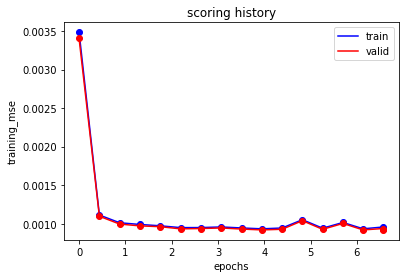

In [14]:
autoenc_history = autoencoder_model.score_history()

x = autoenc_history['epochs']
y = autoenc_history['training_mse']
plt.plot(x,y,'bo')
line1, = plt.plot(x,y,'b-')
y = autoenc_history['validation_mse']
plt.plot(x,y,'ro')
line2, = plt.plot(x,y,'r-')
plt.autoscale(enable=True, axis='both', tight=None)
plt.legend((line1,line2),('train','valid'))
plt.xlabel('epochs')
plt.ylabel('training_mse')
plt.title('scoring history')
plt.show()

## calculate reconstruction error on the training and test sets

In [15]:
recon_error_train = autoencoder_model.anomaly(hf_train, per_feature=False)
df_recon_error_train = h2o.as_list(recon_error_train, use_pandas=True, header=True)
df_train = h2o.as_list(hf_train, use_pandas=True, header=True)
df_recon_error_train['Ground-truth Class'] = df_train['Ground-truth Class']

recon_error_test = autoencoder_model.anomaly(hf_test, per_feature=False)
df_recon_error_test = h2o.as_list(recon_error_test, use_pandas=True, header=True)
df_test = h2o.as_list(hf_test, use_pandas=True, header=True)
df_recon_error_test['Ground-truth Class'] = df_test['Ground-truth Class']

df_recon_error_train.head(5)

,Reconstruction.MSE,Ground-truth Class
0,0.000371,normal
1,0.000565,normal
2,0.001551,normal
3,0.001227,normal
4,0.000445,normal


## plot the reconstruction error on the train set

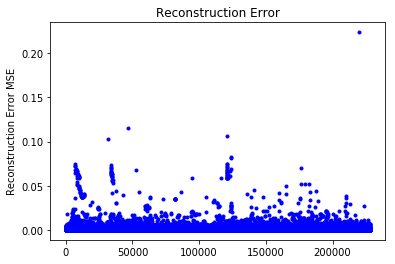

In [16]:
x=list(df_recon_error_train.index)
y=df_recon_error_train['Reconstruction.MSE']
line1 = plt.plot(x,y,'b.')
plt.autoscale(enable=True, axis='both', tight=None)
plt.ylabel('Reconstruction Error MSE')
plt.title('Reconstruction Error')
plt.show()

## We'll pretend that we don't know the labeled reponses, then the threshold for anomaly determination can't be optimised in terms of a confusion matrix

In [17]:
df_recon_error_train['Reconstruction.MSE'].quantile(q=0.999)

0.018990811425358193

### we'll select 0.02 as the threshold 
    - reconstriction error > 0.02 --> 'anomaly'

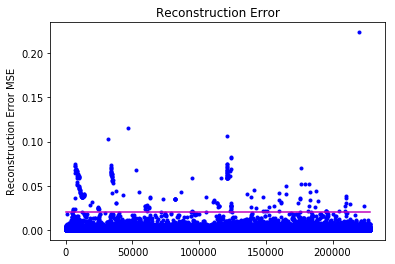

In [18]:
x=list(df_recon_error_train.index)
y=df_recon_error_train['Reconstruction.MSE']
line1, = plt.plot(x,y,'b.')
line2, = plt.plot([x[0],x[-1]],[0.02,0.02],'m-')
plt.autoscale(enable=True, axis='both', tight=None)
plt.ylabel('Reconstruction Error MSE')
plt.title('Reconstruction Error')
plt.show()

## create new response labels based on our unsupervised model and unoptimized threshold
- we'll store these labels in a new column

In [19]:
hf_train['Reconstruction.MSE'] = recon_error_train['Reconstruction.MSE']
hf_train['Unsupervised_Class'] = 'normal'
mask = hf_train['Reconstruction.MSE'] > 0.02
hf_train[mask,'Unsupervised_Class'] = 'anomaly'
hf_train['Unsupervised_Class'] = hf_train['Unsupervised_Class'].asfactor()

hf_test['Reconstruction.MSE'] = recon_error_test['Reconstruction.MSE']
hf_test['Unsupervised_Class'] = 'normal'
mask = hf_test['Reconstruction.MSE'] > 0.02
hf_test[mask,'Unsupervised_Class'] = 'anomaly'
hf_test['Unsupervised_Class'] = hf_test['Unsupervised_Class'].asfactor()

In [20]:
train_gb = hf_train.group_by('Unsupervised_Class').count().get_frame()
mask = train_gb['Unsupervised_Class'] == 'anomaly'
print('%anomaly train split =' ,train_gb[mask,:]['nrow'][0,0]/hf_train.shape[0]*100)
test_gb = hf_test.group_by('Unsupervised_Class').count().get_frame()
mask = test_gb['Unsupervised_Class'] == 'anomaly'
print('%anomaly test split =' ,test_gb[mask,:]['nrow'][0,0]/hf_test.shape[0]*100)

%anomaly train split = 0.09601767777519588
%anomaly test split = 0.09696072209294126


## Now we'll set-up supervised learning with AutoML using the unsupervised predicted labels

In [21]:
y = 'Unsupervised_Class'
X = hf_train.columns
X.remove(y)
X.remove('Time')
X.remove('Ground-truth Class')
X.remove('Reconstruction.MSE')

In [22]:
aml = H2OAutoML(max_runtime_secs=800,
                include_algos=['XGBoost','GBM','DRF'],
                nfolds=5,
                max_models=4,
                balance_classes=False,
                seed=42)
aml.train(x=X,
          y=y,
          training_frame=hf_train,
          leaderboard_frame=hf_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [23]:
lb = aml.leaderboard

lb

model_id,auc,logloss,mean_per_class_error,rmse,mse
DRF_1_AutoML_20190901_192640,0.999999,0.000202128,0.0181818,0.00707547,5.00623e-05
XGBoost_3_AutoML_20190901_192640,0.999986,0.00031438,0.0363725,0.00914178,8.35722e-05
XGBoost_1_AutoML_20190901_192640,0.999984,0.000352762,0.0363725,0.00964593,9.3044e-05
XGBoost_2_AutoML_20190901_192640,0.999944,0.000537358,0.0454722,0.0116815,0.000136458


## Let's take a look at the confusion matrix of **DRF_1_AutoML_20190901_192640**

In [24]:
model = h2o.get_model(lb[0,'model_id'])

### confusion matrix for cross-validation (nfolds=5)

In [25]:
model.confusion_matrix(xval=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.625: 

,,anomaly,normal,Error,Rate
0,anomaly,213.0,6.0,0.0274,(6.0/219.0)
1,normal,11.0,227853.0,0.0,(11.0/227864.0)
2,Total,224.0,227859.0,0.0001,(17.0/228083.0)


### confusion maxtrix for test samples

In [26]:
test_results = model.predict(hf_test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [27]:
# we'll use the max f1 threshold (=0.625) for the xval samples
mask = test_results['normal'] > 0.625
test_results[mask,'predict'] = 'normal'
test_results[~mask,'predict'] = 'anomaly'

test_results['Ground-truth Class'] = hf_test['Ground-truth Class']
test_results['Unsupervised_Class'] = hf_test['Unsupervised_Class']

#convert to pandas dataframe
df_test_results = h2o.as_list(test_results, use_pandas=True, header=True)

In [28]:
df_test_results.head()

,predict,anomaly,normal,Ground-truth Class,Unsupervised_Class
0,normal,0.0,1.0,normal,normal
1,normal,0.0,1.0,normal,normal
2,normal,0.0,1.0,normal,normal
3,normal,0.0,1.0,normal,normal
4,normal,0.0,1.0,normal,normal


## confusion matrix helper function

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [30]:
class_names = ['anomaly','normal']

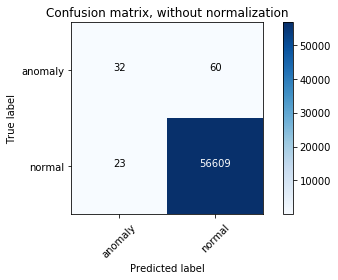

In [31]:
cnf_matrix = confusion_matrix(df_test_results['Ground-truth Class'], df_test_results['Unsupervised_Class'], labels=class_names)
# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

# Shapley explanantions

In [32]:
contributions = model.predict_contributions(hf_test)

In [33]:
contributions.head(5)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,BiasTerm
0.033397,0.0333508,0.0333486,0.0333806,0.0333323,0.0333349,0.0333565,0.0333414,0.0333551,0.0334792,0.0333452,0.0333738,0.0333379,0.0333521,0.0333374,0.0333662,0.0333747,0.0333893,0.0333369,0.0333603,0.0333383,0.0333318,0.0333406,0.0333299,0.033342,0.0333345,0.0333365,0.0333399,0.0333375,0.0327187
0.0333719,0.0333555,0.0333538,0.0333832,0.0333403,0.033335,0.0333564,0.0333394,0.033352,0.0334778,0.033347,0.0333868,0.0333391,0.0333536,0.0333371,0.0333675,0.0333701,0.033392,0.0333327,0.0333548,0.0333327,0.0333351,0.0333401,0.0333377,0.0333417,0.0333331,0.0333363,0.033341,0.0333375,0.0327187
0.0334009,0.0333504,0.0333475,0.0333778,0.033341,0.0333346,0.0333565,0.0333411,0.0333554,0.0334636,0.0333459,0.0333765,0.0333366,0.0333535,0.0333367,0.0333673,0.0333743,0.0333868,0.0333362,0.0333581,0.0333375,0.0333359,0.0333404,0.033336,0.0333418,0.0333344,0.0333365,0.0333404,0.0333375,0.0327187
0.033402,0.0333551,0.033355,0.0333837,0.0333391,0.0333353,0.0333558,0.0333406,0.0333493,0.0334592,0.0333448,0.033375,0.0333383,0.0333538,0.0333332,0.0333669,0.0333745,0.0333964,0.033333,0.0333624,0.0333317,0.0333352,0.0333403,0.0333292,0.0333433,0.0333344,0.033336,0.0333402,0.0333378,0.0327187
0.0333994,0.033351,0.0333488,0.0333799,0.033341,0.033335,0.0333577,0.0333412,0.0333544,0.0334599,0.0333467,0.0333749,0.0333372,0.0333519,0.0333359,0.0333674,0.0333742,0.0333889,0.0333368,0.0333615,0.0333382,0.0333361,0.0333404,0.0333338,0.0333416,0.0333331,0.0333364,0.0333403,0.0333375,0.0327187


In [34]:
# convert the H2O Frame to use with shap's visualization functions
contributions_matrix = contributions.as_data_frame().as_matrix()
# shap values are calculated for all features
shap_values = contributions_matrix[:,0:-1]
# expected values is the last returned column
expected_value = contributions_matrix[:,-1].min()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [35]:
X = df_test.iloc[:,1:-1]

## find indices of the test set where both autoencoder and the model prediction are both 'anomaly'

In [36]:
list1 = df_test_results.index[
        (df_test_results['Unsupervised_Class'] == 'anomaly') \
        & (df_test_results['predict'] == 'anomaly')
        ].tolist()

In [37]:
list1

[1213,
 1331,
 1367,
 1763,
 2100,
 2123,
 2151,
 2229,
 2629,
 2631,
 2685,
 2706,
 2768,
 2942,
 3019,
 3050,
 3415,
 3658,
 5450,
 5981,
 8414,
 8423,
 8431,
 8466,
 8485,
 8499,
 8556,
 8596,
 8770,
 10021,
 14778,
 14788,
 18404,
 28198,
 28588,
 28961,
 30015,
 30039,
 30041,
 30042,
 30043,
 30047,
 30101,
 30102,
 30103,
 30198,
 30673,
 30842,
 33546,
 42086,
 43787,
 45283,
 46261,
 51089,
 56610]

In [38]:
len(list1)

55

## we'll plot the force plots where the ground_truth and unsupervised both 
- note: the plot is using javascript which may not render properly in github (click the link to the external nbviewer at the top right of the notebook)
- the variables in blue are pushing the model to predict 'anomaly'

In [39]:
shap.initjs()
# visualize the prediction explanation
shap.force_plot(expected_value, shap_values[list1,:], X.iloc[list1,:])

## It seems that V10 is often pushing the model towards predicting 'anomaly'

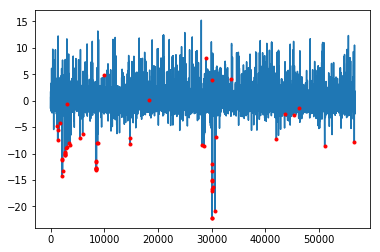

In [40]:
plt.plot(range(0,df_test['V10'].shape[0]),df_test['V10'])
plt.plot(list1,df_test['V10'][list1],'r.')

plt.show()

## check 'V10' vs 'V12' feature space

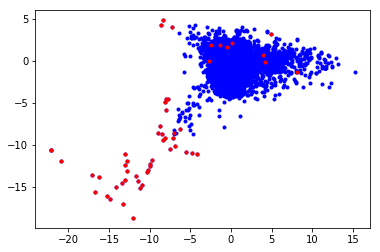

In [42]:
plt.plot(df_test['V10'],df_test['V12'],'b.')
plt.plot(df_test['V10'][list1],df_test['V12'][list1],'r.')

plt.show()

## Now we'll check model: **XGBoost_3_AutoML_20190901_192640**
- in general, we shouldn't expect the shapley values to be the exactly the same for different models

In [48]:
model1 = h2o.get_model(lb[1,'model_id'])

In [45]:
contributions = model.predict_contributions(hf_test)

In [49]:
model1.confusion_matrix(xval=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5455666184425354: 

,,anomaly,normal,Error,Rate
0,anomaly,199.0,20.0,0.0913,(20.0/219.0)
1,normal,4.0,227860.0,0.0,(4.0/227864.0)
2,Total,203.0,227880.0,0.0001,(24.0/228083.0)


In [50]:
test_results = model.predict(hf_test)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [51]:
# we'll use the max f1 threshold (=0.54) for the xval samples
mask = test_results['normal'] > 0.54
test_results[mask,'predict'] = 'normal'
test_results[~mask,'predict'] = 'anomaly'

test_results['Ground-truth Class'] = hf_test['Ground-truth Class']
test_results['Unsupervised_Class'] = hf_test['Unsupervised_Class']

#convert to pandas dataframe
df_test_results = h2o.as_list(test_results, use_pandas=True, header=True)

In [52]:
# convert the H2O Frame to use with shap's visualization functions
contributions_matrix = contributions.as_data_frame().as_matrix()
# shap values are calculated for all features
shap_values = contributions_matrix[:,0:-1]
# expected values is the last returned column
expected_value = contributions_matrix[:,-1].min()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [53]:
X = df_test.iloc[:,1:-1]

In [54]:
list1 = df_test_results.index[
        (df_test_results['Unsupervised_Class'] == 'anomaly') \
        & (df_test_results['predict'] == 'anomaly')
        ].tolist()

In [55]:
shap.initjs()
# visualize the prediction explanation
shap.force_plot(expected_value, shap_values[list1,:], X.iloc[list1,:])

## check 'V10' vs 'V4' feature space

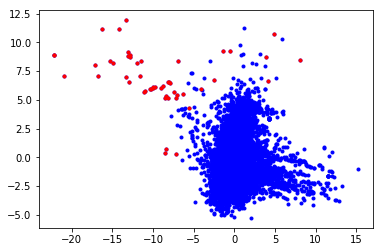

In [56]:
plt.plot(df_test['V10'],df_test['V4'],'b.')
plt.plot(df_test['V10'][list1],df_test['V4'][list1],'r.')

plt.show()

In [57]:
h2o.cluster().shutdown()

H2O session _sid_a363 closed.
